<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Model" data-toc-modified-id="Image-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Model</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Image-Augmentation" data-toc-modified-id="Image-Augmentation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Image Augmentation</a></span></li></ul></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,keras

Using TensorFlow backend.


Ethen 2018-08-15 15:19:15 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2
keras 2.1.5


# Image Model

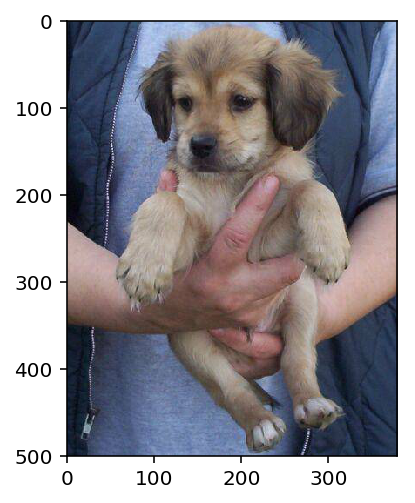

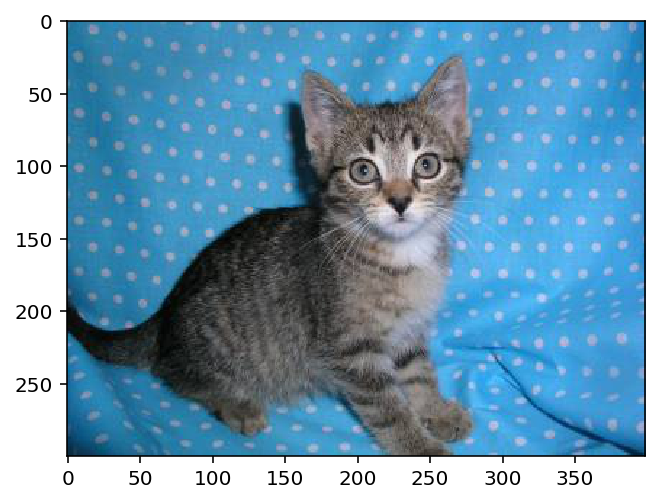

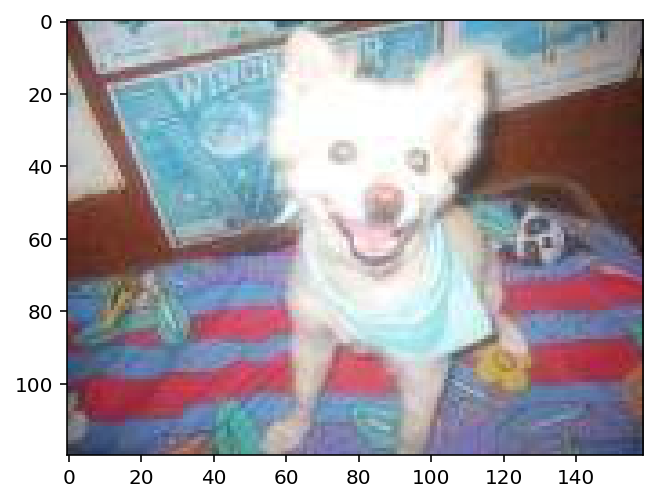

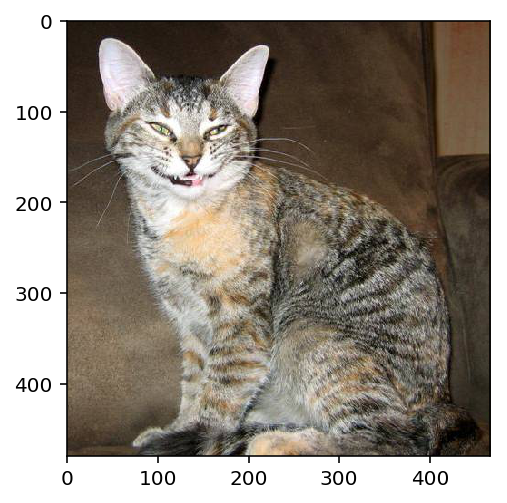

In [2]:
import os
from PIL import Image

# base path that stores the cats & dogs dataset downloaded from kaggle
original_img_dir = os.path.join('all', 'train')

# image are named img as per keras convention
img_paths = ['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg']
for img_path in img_paths:
    img_input_path = os.path.join(original_img_dir, img_path)
    img = np.array(Image.open(img_input_path))
    plt.imshow(img)
    plt.show()

## Data Preprocessing

This section does some simple preprocessing, including:

- Setting up the training, validation and test dataset.
- Organizing the image into a more keras friendly way (more on this in its section later).

In [3]:
def create_data_and_label(original_img_dir):
    result = []
    for img_path in os.listdir(original_img_dir):
        # avoid hidden files like .DSstore files
        # that are generated on mac
        if img_path.startswith('.'):
            continue

        # the way we extracted the labels here is specific to this
        # dataset, though we can change this logic to make it
        # applicable for other dataset
        if img_path.startswith('cat'):
            label = 'cat'
        elif img_path.startswith('dog'):
            label = 'dog'
        else:
            raise ValueError('there should only be cat and dog for the label')

        result.append((img_path, label))

    data_and_label = pd.DataFrame(result, columns=['img_path', 'label'])
    return data_and_label


data = create_data_and_label(original_img_dir)
print('dimension: ', data.shape)
data.head()

dimension:  (25000, 2)


,img_path,label
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [4]:
def train_val_test_split(data, val_size=0.2, test_size=0.1, random_state=1234, label_col=None):
    """
    Train/test split twice to achieve train/validation/test three way split.

    For classification task, we can pass in label_col to perform a stratified split,
    whereas for regression task, we can ignore the argument to perform a random split.
    """
    stratify = None
    if label_col is not None:
        stratify = data[label_col]

    data_train, data_test = train_test_split(
        data, test_size=test_size, random_state=random_state, stratify=stratify)

    if label_col is not None:
        stratify = data_train[label_col]

    data_train, data_val = train_test_split(
        data_train, test_size=val_size, random_state=random_state, stratify=stratify)
    return data_train, data_val, data_test


val_size = 0.2
test_size = 0.1
split_random_state = 1234
label_col = 'label'

df_train, df_val, df_test = train_val_test_split(
    data, val_size, test_size, split_random_state, label_col)

df_groups = (df_train, df_val, df_test), ('train', 'validation', 'test')
for df_subset, df_type in zip(*df_groups):
    print(df_type + ' dimension: {}, {}'.format(*df_subset.shape))

train dimension: 18000, 2
validation dimension: 4500, 2
test dimension: 2500, 2


In [5]:
from shutil import copyfile
from joblib import Parallel, delayed


def create_all_keras_file(img_ids, labels, unique_labels, 
                          keras_dir, img_dir, folder_name,
                          n_jobs=-1, verbose=True, pre_dispatch='2*n_jobs'):
    """
    Create the keras way of organizing the files so it
    can be called via keras' ImageDataGenerator, which
    allows for not reading in the images into memory all at 
    once; the way it is done is by storing training
    and test set in separate sub-folder and under
    each sub-folder is a folder for each class/label's images.

    Parameters
    ----------
    img_ids : list[str]
        Sequence of image ids, i.e. images' file names. Note that
        this assumes the file name already contains the file extension
        and it is not yet the full path. e.g. one img_id might look like
        dog.8011.jpg, whereas the full path to actually read the image
        is data/dog.8011.jpg. This prevents storing the 'data' string
        across all of our image path.

    labels : list[str]
        Images' corresponding label, length should match img_ids.

    unique_labels : list[str]
        Unique labels in the dataset, the name will be used to 
        generate the sub-folder that identifies each class.

    keras_dir : str
        Filepath that the keras' folder will be created.

    img_dir : str
        Filepath that contains the original images.

    folder_name : str
        Folder name of the 1st level sub-folder after the keras_dir,
        e.g. setting it to 'train' to indicate that this will be the
        training data set (all the images of the training dataset will
        go under this folder).

    n_jobs, verbose, pre_dispatch
        Joblib parameter for parallelizing the process.

    Returns
    -------
    data_dir : str
        Path of the folder_name, can/will be used for passing it to
        keras' ImageDataGenerator for reading batches of images.
    """
    # data_dir refers to whether it's storing the training or testing data
    data_dir = os.path.join(keras_dir, folder_name)
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

        # create a sub-folder inside data_dir for every unique labels
        for label in unique_labels:
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                os.mkdir(label_dir)

        # copying file is IO-bound, thus we are not blocked by the GIL
        # and can leverage the faster multi-threading instead of multi-processing
        parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
                            pre_dispatch=pre_dispatch, backend='threading')
        parallel(delayed(create_keras_file)(img_id, label, img_dir, data_dir) 
                 for img_id, label in zip(img_ids, labels))

    return data_dir


def create_keras_file(img_id, label, img_dir, data_dir):
    """
    Copy the image from the orginal folder to the
    corresponding keras folder.
    """
    src_path = os.path.join(img_dir, img_id)
    dest_path = os.path.join(data_dir, label, img_id)

    # the following link contains a pretty good overview of copying single
    # files in python
    # https://www.pythoncentral.io/how-to-copy-a-file-in-python-with-shutil/
    copyfile(src_path, dest_path)

In [7]:
ids_col = 'img_path'
unique_labels = data[label_col].unique()
print('unique labels: ', str(unique_labels))

# set a new folder for storing images in
# keras' ImageGenerator way and reate the
# folder for all train/validation/test set
keras_dir = 'keras_img'
if not os.path.isdir(keras_dir):
    os.makedirs(keras_dir, exist_ok=True)

keras_img_dirs = {}
for df_subset, df_type in zip(*df_groups):
    img_ids = df_subset[ids_col].values
    labels = df_subset[label_col].values

    keras_img_dir = create_all_keras_file(
        img_ids, labels, unique_labels, 
        keras_dir, original_img_dir, df_type, verbose=0)

    keras_img_dirs[df_type] = keras_img_dir

keras_img_dirs

unique labels:  ['dog' 'cat']


{'train': 'keras_img/train',
 'validation': 'keras_img/validation',
 'test': 'keras_img/test'}

## Model Training

In [8]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
rescale = 1. / 255
train_datagen = ImageDataGenerator(rescale=rescale)
test_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        keras_img_dirs['train'],
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        keras_img_dirs['validation'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 18000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [17]:
epochs = 3
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/3
100/100 [==============================] - 66s 661ms/step - loss: 0.5991 - acc: 0.6670 - val_loss: 0.5831 - val_acc: 0.6930
Epoch 2/3
100/100 [==============================] - 68s 681ms/step - loss: 0.5941 - acc: 0.6960 - val_loss: 0.5838 - val_acc: 0.6790
Epoch 3/3
100/100 [==============================] - 65s 650ms/step - loss: 0.5856 - acc: 0.6915 - val_loss: 0.5614 - val_acc: 0.7260


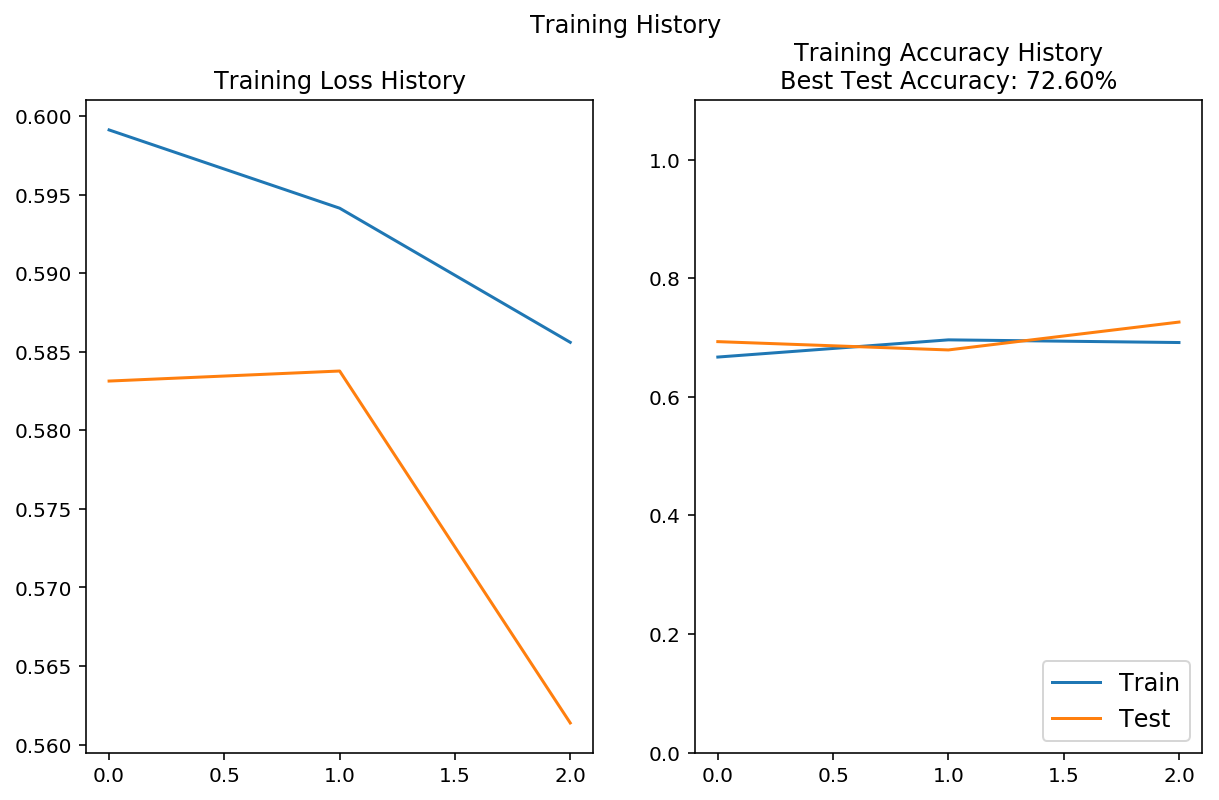

In [18]:
def viz_history(history, fig_path=None): 
    fig, ax = plt.subplots(1, 2, figsize = (10, 6))
    fig.suptitle('Training History')
    
    ax[0].plot(history['loss'], label = 'Train')
    ax[0].plot(history['val_loss'], label = 'Test')
    ax[0].set_title('Training Loss History')
    
    best_acc = np.max(history['val_acc']) * 100
    ax[1].plot(history['acc'], label = 'Train')
    ax[1].plot(history['val_acc'], label = 'Test')    
    ax[1].set_ylim([0, 1.1]) 
    ax[1].set_title('Training Accuracy History\nBest Test Accuracy: {:0.2f}%'.format(best_acc))     
    ax[1].legend(loc = 'lower right', fontsize = 12)
    
    if fig_path is not None:
        plt.savefig(fig_path)

    plt.show()
    
    
#fig_path = 'history_{}.png'.format(model_name)
viz_history(history.history)

## Image Augmentation

In [19]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

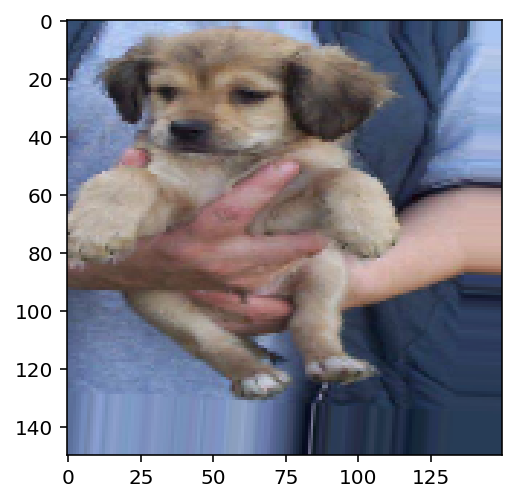

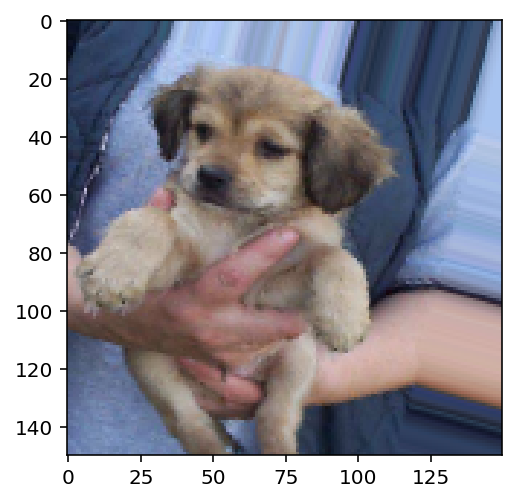

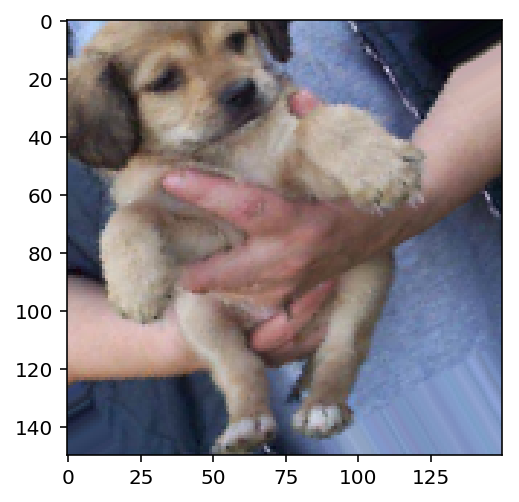

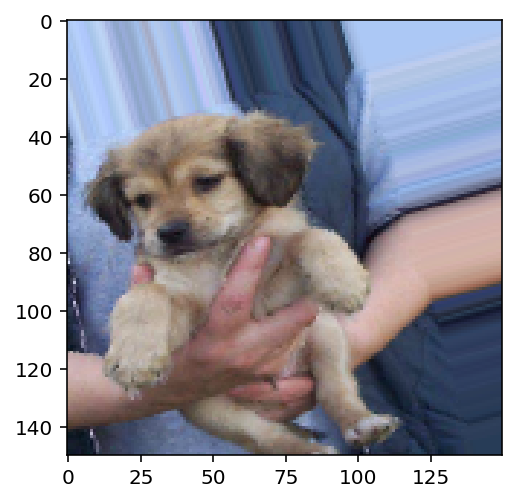

In [20]:
from keras.preprocessing import image

# We pick one image to "augment"
img_input_path = os.path.join(original_img_dir, 'dog.8011.jpg')

# Read the image and resize it
img = image.load_img(img_input_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
# import time

# start = time.time()
# elapse = time.time() - start
# print('creating folders elapsed time: ', elapse)